In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
directory = "/content/drive/MyDrive/FINAL_COMBINED_AUGMENT_DATASET_FOR_PAPER_FOR_MODEL2"

In [4]:
Name=[]
for file in os.listdir(directory):
    Name+=[file]
print(Name)

['Fresh', 'NonFresh']


In [5]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

In [6]:
File=[]
for file in os.listdir(directory):
    File+=[file]
    print(file)

Fresh
NonFresh


##### don't run augmentation

Augmentation

In [ ]:
def augment(image_path, folder_path):
  datagen_intial = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
  image=load_img(image_path, grayscale=False, color_mode='rgb', target_size=(225,225))
  image=img_to_array(image)
  # image=image/255.0
  image = image.reshape((1,) + image.shape)
  i = 0
  for batch in datagen_intial.flow(image, batch_size=1, 
                                    save_to_dir= folder_path,
                                    save_prefix = 'fish', save_format = 'jpeg'):
    i += 1
    if i > 20:
      break

src_path = "/content/drive/MyDrive/FINAL_FISH_dataset_for_paper_for_model"
dest_path = "/content/drive/MyDrive/FINAL_COMBINED_AUGMENT_DATASET_FOR_PAPER_FOR_MODEL2"
for file in File:
  path = os.path.join(directory,file)
  dest_path1 = os.path.join(dest_path, file)
  for im in os.listdir(path):
    augment(os.path.join(path,im), dest_path1)

KeyboardInterrupt: ignored

seperating training and testing data

In [7]:
directory = "/content/drive/MyDrive/FINAL_COMBINED_AUGMENT_DATASET_FOR_PAPER_FOR_MODEL2"

In [8]:
trainx0=[]
testx0=[]
trainy0=[]
testy0=[]
count=0
for file in File:
  path=os.path.join(directory,file)
  t=0
  for im in os.listdir(path):
    image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(50,50))
    image=img_to_array(image)
    image=image/255.0
    n=len(os.listdir(path))
    if t<(n//10)*8:
        trainx0.append(image)
        trainy0.append(count)
    else:   
        testx0.append(image)
        testy0.append(count)
    t+=1
  count=count+1
  print(len(trainx0), len(testx0), len(trainy0), len(testy0))

680 178 680 178
1320 341 1320 341


In [9]:
print(len(trainx0), len(testx0), len(trainy0), len(testy0))

1320 341 1320 341


In [11]:

trainy2=to_categorical(trainy0)
X_train=np.array(trainx0)
y_train=np.array(trainy2)
X_test=np.array(testx0)

Splitting training data into training and validation

In [12]:
trainx,testx,trainy,testy=train_test_split(X_train,y_train,test_size=0.2,random_state=44)

In [13]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1056, 50, 50, 3)
(264, 50, 50, 3)
(1056, 2)
(264, 2)


In [14]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

Developing Model

In [15]:
# Load the ResNet50 model
pretrained_model = tf.keras.applications.resnet50.ResNet50(
    input_shape=(50, 50, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze all the layers
pretrained_model.trainable = False

# Create a new output layer
output_layer = tf.keras.layers.Dense(2, activation='softmax')

# Combine the ResNet50 model with the new output layer
model = tf.keras.Sequential([
    pretrained_model,
    output_layer
])

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
# Fine-tune the last few layers of the ResNet50 model
pretrained_model.trainable = True
fine_tune_at = 100
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable = False

In [17]:

# Re-compile the model with a smaller learning rate
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    metrics=['accuracy']
    
)

In [18]:
# Train the model again with the last few layers unfrozen
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=20)

Epoch 1/20
33/33 [==============================] - 31s 126ms/step - loss: 0.7947 - accuracy: 0.5398 - val_loss: 0.6877 - val_accuracy: 0.4773
Epoch 2/20
33/33 [==============================] - 2s 46ms/step - loss: 0.7262 - accuracy: 0.5994 - val_loss: 0.6936 - val_accuracy: 0.4773
Epoch 3/20
33/33 [==============================] - 2s 47ms/step - loss: 0.6975 - accuracy: 0.6345 - val_loss: 0.6949 - val_accuracy: 0.4773
Epoch 4/20
33/33 [==============================] - 2s 47ms/step - loss: 0.6449 - accuracy: 0.6837 - val_loss: 0.6731 - val_accuracy: 0.5038
Epoch 5/20
33/33 [==============================] - 2s 48ms/step - loss: 0.6530 - accuracy: 0.6468 - val_loss: 0.6806 - val_accuracy: 0.5189
Epoch 6/20
33/33 [==============================] - 2s 46ms/step - loss: 0.6414 - accuracy: 0.6979 - val_loss: 0.6582 - val_accuracy: 0.6250
Epoch 7/20
33/33 [==============================] - 2s 48ms/step - loss: 0.5925 - accuracy: 0.7102 - val_loss: 0.6390 - val_accuracy: 0.6629
Epoch 8/20


Model Validation

In [19]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

9/9 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.67      0.94      0.78       126
           1       0.91      0.57      0.70       138

    accuracy                           0.75       264
   macro avg       0.79      0.75      0.74       264
weighted avg       0.79      0.75      0.74       264



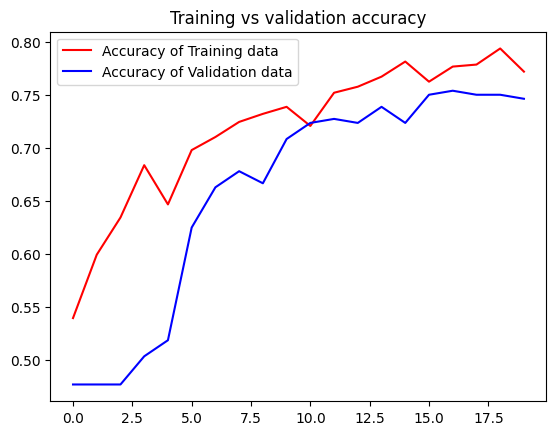

<Figure size 640x480 with 0 Axes>

In [20]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

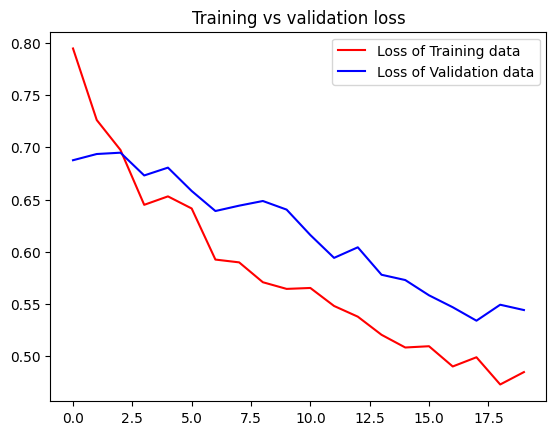

<Figure size 640x480 with 0 Axes>

In [21]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

Model Evaluation

In [22]:
pred2=model.predict(X_test)
print(pred2[0:10])

PRED=[]
for item in pred2:
    value2=np.argmax(item)      
    PRED+=[value2]
print(PRED[0:10])

11/11 [==============================] - 1s 61ms/step
[[9.9990022e-01 9.9802230e-05]
 [9.9536633e-01 4.6336330e-03]
 [9.9999964e-01 3.4525226e-07]
 [9.9995005e-01 4.9939525e-05]
 [9.9585271e-01 4.1473587e-03]
 [9.9648958e-01 3.5104158e-03]
 [9.9780017e-01 2.1997676e-03]
 [9.9016458e-01 9.8354453e-03]
 [9.9933869e-01 6.6129048e-04]
 [1.0000000e+00 3.2209599e-08]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
ANS=testy0
ANS[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [24]:
accuracy=accuracy_score(ANS,PRED)
print(accuracy)

0.8064516129032258


Testing

In [25]:
directory_test = "/content/drive/MyDrive/Test_purpose_281122"

In [29]:
test_File=[]
for file in os.listdir(directory_test):
    test_File+=[file]
    print(file)

NonfreshEyes.webp
FreshFishEyes.jpg
NonFreshEyes1.jpeg
fresh_gills1.jfif
fresh_gills17-12.jfif
fresh_eyes17-12.jfif
fresh_eyes2.jfif
NF.png
Fresh.jpg
NonFreshEyes.jpeg


In [30]:
for file in test_File:
  path0 = os.path.join(directory_test, file)
  image=load_img(path0,target_size=(50,50))

  image=img_to_array(image) 
  image=image/255.0
  prediction_image=np.array(image)
  prediction_image= np.expand_dims(image, axis=0)
  prediction=model.predict(prediction_image)
  value=np.argmax(prediction)
  move_name=mapper(value)
  print("Prediction is {}.".format(move_name))

1/1 [==============================] - 0s 37ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 125ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 118ms/step
Prediction is NonFresh.
1/1 [==============================] - 0s 52ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 88ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 41ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 82ms/step
Prediction is NonFresh.
1/1 [==============================] - 0s 165ms/step
Prediction is NonFresh.
1/1 [==============================] - 0s 46ms/step
Prediction is Fresh.
1/1 [==============================] - 0s 147ms/step
Prediction is NonFresh.


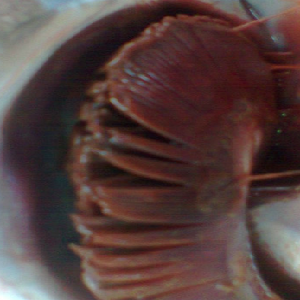

In [26]:
path0 = "/content/drive/MyDrive/Test_purpose_281122/NF.png"
load_img(path0,target_size=(300,300))

In [27]:
image=load_img(path0,target_size=(50,50))

image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [28]:
prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))

KeyboardInterrupt: ignored